## Buscando el modelo óptimo

In [3]:
import logging
import config

from IPython import display
from dataset.TPL import *
import dataset.preprocessing as pre

import numpy as np
import pandas as pd
import time
import pickle
import ftn
# from pprint import pprint
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
%reload_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)

Creamos nuevamente nuestro modelo: (no entraremos en mayor detalle)

In [4]:
gravity_train=pickle.load(open("gravity_train","rb"))
gravity_test=pickle.load(open("gravity_test","rb"))

In [5]:
import re
#Implementamos un tokenizador que separa las palabras unicamente cuando encuentre espacios.
def my_tokenizer(text):
    # split based on whitespace
    return re.split("\\s+",text)

In [6]:
def vectorizer(info_train):
    
    #Info_train: data prepocessed for training 
    
    #Clase del CountVectorizer() con el tokenizador implementado
    vect=CountVectorizer(tokenizer=my_tokenizer,lowercase=False)
    
    #Dejamos todo como str (la info contiene números)
    info_train=info_train.apply(str)
    
    #Aplicamos el C_V y obtenemos la matrix token-frequency
    info_train = vect.fit_transform(info_train)
    
    #return de matrix token-frequency in info_train and the class CountVectorizer()
    return info_train, vect

In [8]:
#Creamos la matriz toke-frequency para nuestra data de entrenamiento:
info_train_v, v= vectorizer(gravity_train)

Para llevar a cabo la búsqueda del modelo más óptimo, utilizaremos la herramienta [GridSearchCV.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de SKlearn.

GridSearchCV: is a library function that is a member of sklearn’s model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

In [9]:
%%time
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'learning_decay': [.5, .7, .9]}

#n_components: número de tópicos
#learning_decay: It is a parameter that control learning rate 
#                in the online learning method. The value should be set 
#                between (0.5, 1.0] to guarantee asymptotic convergence

# Init the Model
lda_opt = LatentDirichletAllocation(max_iter=10)

# Init Grid Search Class
model = GridSearchCV(lda_opt, param_grid=search_params)

# Do the Grid Search
model.fit(info_train_v)

CPU times: total: 18min 3s
Wall time: 18min 3s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15]})

In [10]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(info_train_v))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 12}
Best Log Likelihood Score:  -1593750.0914103708
Model Perplexity:  79.05495789499058


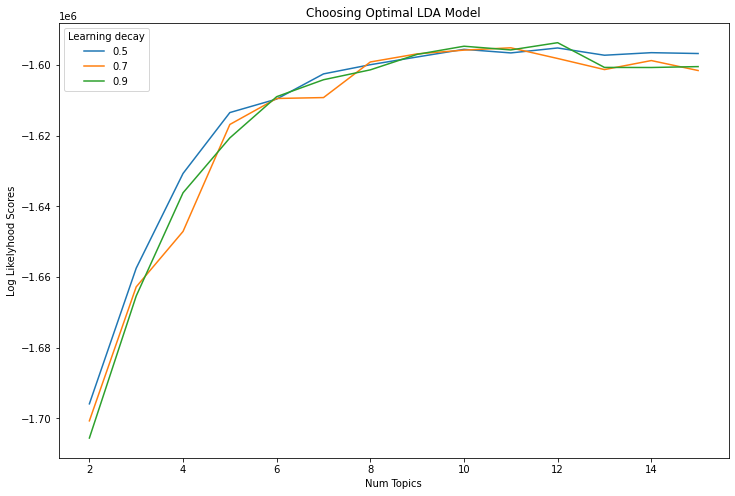

In [13]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = []
log_likelyhoods_7 = []
log_likelyhoods_9 = []
n_topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for i in range(len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.5:
       log_likelyhoods_5.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.7:
       log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.9:
       log_likelyhoods_9.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [15]:
#Guardamos el mejor modelo:
model=open("gravity_bestmodel","wb")
pickle.dump(best_lda_model,model)
model.close()